In [40]:
import gym
!pip install torchbnn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchbnn as bnn

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import os

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [41]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [42]:
# Initialize CartPole environment
env_name = 'CartPole-v1'
#env_name = 'MountainCarContinuous-v0'
#env_name = 'MountainCar-v0'
#env_name = 'Pendulum-v1'

# Create the CartPole environment
env = gym.make(env_name)

In [43]:
class BayesianNN(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation):
        super(BayesianNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_nodes = hidden_layer_nodes
        self.activation = activation
        
        # Define the layers
#         self.input_layer = nn.Linear(input_size, hidden_layer_nodes)
        self.input_layer = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_size, out_features=hidden_layer_nodes)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
#           self.hidden_layers.append(nn.Linear(hidden_layer_nodes, hidden_layer_nodes))
            self.hidden_layers.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden_layer_nodes, out_features=hidden_layer_nodes))
#        self.output_layer = nn.Linear(hidden_layer_nodes, output_size)
        self.output_layer = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden_layer_nodes, out_features=output_size)
        

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        output = self.output_layer(x)
        return output


In [44]:
#Initialize parameters for model
action = env.action_space.sample()

if isinstance(action, int):
    input_size = env.observation_space.shape[0] + 1
elif isinstance(action, np.ndarray):
    input_size = env.observation_space.shape[0] + len(action)

output_size = env.observation_space.shape[0] + 2
num_hidden_layers = 3
hidden_layer_nodes = 20
activation = F.relu
learning_rate = 0.01
dropout_prob = 0.3
num_networks = 5

# Instantiate the model
model = BayesianNN(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation).to(device)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
batch_size = 32

num_samples = '50k'

# Load datasets
with open(env_name + '_' + num_samples + '_train_dataset.pkl', 'rb') as f:
    train_dataset_loaded = pickle.load(f)

with open(env_name + '_' + num_samples + '_test_dataset.pkl', 'rb') as f:
    test_dataset_loaded = pickle.load(f)

train_loader = torch.utils.data.DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle=False)

In [46]:
model_weights_file_path = 'bayesian_'+ env_name + '_' + num_samples +'.pth' 

'''
if os.path.exists(model_weights_file_path):
    model.load_state_dict(torch.load('model_weights.pth'))
'''

# Training loop with evaluation
num_epochs = 50
train_losses = []
test_losses = []
save_interval = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mse_loss(outputs, labels) + kl_weight * kl_loss(model)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss}")
    train_losses.append(epoch_train_loss)
    
    # Evaluation on test data
    #model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = mse_loss(outputs, labels) + kl_weight * kl_loss(model)
            running_test_loss += test_loss.item()
    epoch_test_loss = running_test_loss / len(test_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss}")
    
    if (epoch + 1) % save_interval == 0:
        # Save model state
        torch.save(model.state_dict(), f'bayesian_{env_name}_{num_samples}_epoch_{epoch+1}.pt')
        
    test_losses.append(epoch_test_loss)

Epoch [1/50], Training Loss: 4.3209929001808165
Epoch [1/50], Test Loss: 2.176631441893288
Epoch [2/50], Training Loss: 1.7719168792724609
Epoch [2/50], Test Loss: 1.5489615304782367
Epoch [3/50], Training Loss: 1.5208581707954407
Epoch [3/50], Test Loss: 1.5089779858010264
Epoch [4/50], Training Loss: 1.4358794254779816
Epoch [4/50], Test Loss: 1.4459783335844167
Epoch [5/50], Training Loss: 1.399498890209198
Epoch [5/50], Test Loss: 1.3802752746179843
Epoch [6/50], Training Loss: 1.38739108915329
Epoch [6/50], Test Loss: 1.3216576334386587
Epoch [7/50], Training Loss: 1.3771313128948213
Epoch [7/50], Test Loss: 1.4034194814892242
Epoch [8/50], Training Loss: 1.3788355412483215
Epoch [8/50], Test Loss: 1.3331870884179307
Epoch [9/50], Training Loss: 1.3698842994689941
Epoch [9/50], Test Loss: 1.4189365970821808
Epoch [10/50], Training Loss: 1.356469921875
Epoch [10/50], Test Loss: 1.4153417162240123
Epoch [11/50], Training Loss: 1.3542790043354034
Epoch [11/50], Test Loss: 1.330590953

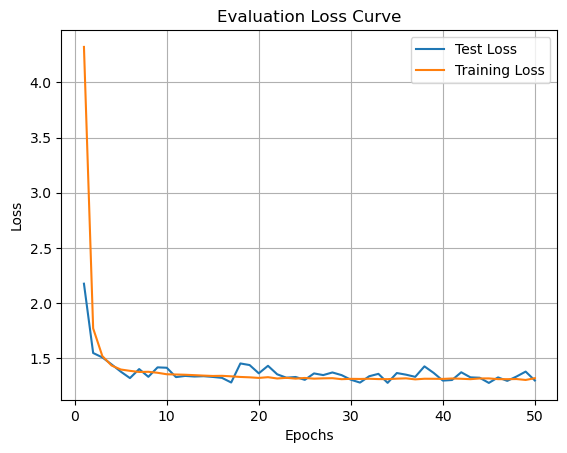

In [47]:
# Plotting the evaluation loss curve
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evaluation Loss Curve')
plt.legend()
plt.grid(True)
# Save the plot
plt.savefig('bayesian_'+ env_name + '_' + num_samples + '_evaluation_loss_curve.png')
plt.show()

In [48]:
# Switch model to evaluation mode
#model.eval()

# Lists to store predictions and true labels
predictions = []
true_labels = []

# Iterate over test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate Mean Squared Error (MSE) and R-squared
mse = mean_squared_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 1.2588964700698853
R-squared: 0.7249796625345267


In [49]:
model_weights_file_path = 'bayesian_'+ env_name + '_' + num_samples +'.pth' 
# Save the trained model
torch.save(model.state_dict(), model_weights_file_path)

In [50]:
# Instantiate the model
model = BayesianNN(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation).to(device)

model.load_state_dict(torch.load(model_weights_file_path))

<All keys matched successfully>